In [16]:
import os
# load multirun yaml Omgeaconf
from omegaconf import OmegaConf
import sys
main_path =  os.path.abspath("..")
sys.path.insert(0, main_path)
from utils.data import DataManager
from utils.plotting import Plotter

from matplotlib import pyplot as plt
import matplotlib.style
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

mpl.style.use('classic')
mpl.rc('image', cmap='viridis')
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


In [17]:
paths = ["Results/Experiment1/28", "Results/Experiment1/19/", "Results/Experiment1_data/7"]
paths = [os.path.abspath(os.path.join(main_path, path)) for path in paths]

best_mse_path = os.path.abspath(os.path.join(main_path, "Results/Experiment1/28/checkpoints/2384/default"))
best_mape_path = os.path.abspath(os.path.join(main_path, "Results/Experiment1/19/checkpoints/1036/default"))
best_data = os.path.abspath(os.path.join(main_path, "Results/Experiment1_data/7/checkpoints/407/default"))

best_model_paths = [best_mse_path, best_mape_path, best_data]

# load cfgs
cfgs = []
plot_classes = []
nc_path_old = ""
for path, best_model_path in zip(paths, best_model_paths):
    cfg = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    cfgs.append(cfg)

    nc_path = os.path.abspath(os.path.join(main_path, cfg.data.data_path))
    if nc_path != nc_path_old:
        DM = DataManager(nc_path = nc_path, 
                    exclusion_radius = 1., 
                    input_coords = ["z_cyl", "r", "CT", "TI_amb"],
                    output_vars = ["U_z", "U_r", "P"], 
                    val_split=0.1, 
                    development_mode=False)
        nc_path_old = nc_path
    plot_class = Plotter(DM, best_model_path, get_complete_set=True)
    plot_classes.append(plot_class)

In [18]:
vars = ["U_z", "U_r", "P"]

In [19]:
# added due to reviewer comment on mean flow
import numpy as np
mean_uz = np.zeros_like(plot_class.unscaled_df_all[0]["U_z"])
mean_ur = np.zeros_like(plot_class.unscaled_df_all[0]["U_r"])
mean_p = np.zeros_like(plot_class.unscaled_df_all[0]["P"])

for df in plot_class.unscaled_df_all:
    mean_uz = mean_uz + df["U_z"]
    mean_ur = mean_ur + df["U_r"]
    mean_p = mean_p + df["P"]

mean_uz = mean_uz / len(plot_class.unscaled_df_all)
mean_ur = mean_ur / len(plot_class.unscaled_df_all)
mean_p = mean_p / len(plot_class.unscaled_df_all)

average_data = np.array([mean_uz, mean_ur, mean_p]).T

In [20]:
vars

['U_z', 'U_r', 'P']

In [22]:
import pandas as pd
import numpy as np

models = ["Wide", "Deep", "Data"]
flowcase_metrics_list = []
saved_err_average_list = []


for model, plot_class in zip(models, plot_classes):

    flowcase_metrics = pd.DataFrame()
    saved_err_average = []
    
    for df_pred, df_ref in zip(plot_class.df_all_predictions_list, plot_class.unscaled_df_all):
        assert len(df_pred["CT"].unique()) == 1
        assert df_pred["CT"].unique() == df_ref["CT"].unique()
        assert len(df_pred["TI_amb"].unique()) == 1
        assert df_pred["TI_amb"].unique() == df_ref["TI_amb"].unique()

        # calculate MSE and MAPE
        pred = df_pred[vars].values.flatten()
        ref = df_ref[vars].values.flatten()
        err = ref - pred
        
        err_vars = (df_ref[vars] - df_pred[vars]).abs().max()


        # added due to reviewer reply
        err_average = average_data.flatten() - pred
        err_average_uz = average_data[:,0] - df_ref["U_z"].values
        err_average_ur = average_data[:,1] - df_ref["U_r"].values
        err_average_p = average_data[:,2] - df_ref["P"].values
        saved_err_average.append(np.array([err_average_uz, err_average_ur, err_average_p]))
        
        MAE_average_flow = np.mean(np.abs(err_average))
        MAE_average_flow_v2 = np.mean(np.abs(average_data.flatten() - ref))

        MSE = np.mean(err**2)
        MAE = np.mean(np.abs(err))
        MAPE = np.mean(np.abs(err/ref))
        
        flowcase_row = pd.DataFrame({"flowcase": df_pred["flowcase"].unique(), "CT": df_pred["CT"].unique(), "TI_amb": df_pred["TI_amb"].unique(), "MSE": MSE, "MAE": MAE, "MAPE": MAPE, "max_err_Uz": err_vars["U_z"], "max_err_Ur": err_vars["U_r"], "max_err_P": err_vars["P"] , "MAE_average_flow": MAE_average_flow, "MAE_average_flow_v2": MAE_average_flow_v2})
        flowcase_metrics = pd.concat([flowcase_metrics, flowcase_row], axis=0)

    flowcase_metrics = flowcase_metrics.pivot(index="CT", columns="TI_amb", values=["MSE", "MAE","MAPE","max_err_Uz","max_err_Ur","max_err_P", "MAE_average_flow", "MAE_average_flow_v2"])
    flowcase_metrics_list.append(flowcase_metrics)
    saved_err_average_list.append(np.array(saved_err_average))

In [23]:
flowcase_metrics_list[0][["max_err_Uz","max_err_Ur"]]

max_err_Uz                                                    \
TI_amb        0.03      0.06      0.09      0.12      0.15      0.18   
CT                                                                     
0.05900   0.014774  0.051002  0.103136  0.159534  0.216882  0.275419   
0.15502   0.047946  0.010794  0.054079  0.107308  0.160859  0.216198   
0.25084   0.101186  0.051552  0.018401  0.055648  0.107934  0.161886   
0.34700   0.156660  0.103103  0.054956  0.018760  0.054906  0.109999   
0.44270   0.214256  0.157410  0.108232  0.056390  0.015143  0.056826   
0.53908   0.275213  0.214012  0.163923  0.111290  0.056437  0.017765   
0.63388   0.338820  0.272110  0.221570  0.167445  0.111957  0.057476   
0.73105   0.408831  0.337385  0.284564  0.228748  0.172432  0.116588   
0.81400   0.473521  0.397540  0.341778  0.284152  0.226964  0.170413   
0.90400   0.550502  0.468934  0.408477  0.348073  0.289317  0.231600   
0.92300   0.567767  0.484894  0.423218  0.362039  0.302964  0.244853   

                                                max_err_Ur            \
TI_amb       0.21      0.24      0.27      0.30       0.03      0.06   
CT                                                                     
0.05900  0.339495  0.411727  0.489443  0.571000   0.007145  0.018140   
0.15502  0.274407  0.338007  0.408843  0.486523   0.022605  0.011039   
0.25084  0.222135  0.286672  0.354517  0.423637   0.046125  0.034065   
0.34700  0.170307  0.233978  0.300904  0.369267   0.070085  0.057070   
0.44270  0.115797  0.177099  0.240932  0.306872   0.094623  0.080361   
0.53908  0.059018  0.117859  0.178448  0.240756   0.120297  0.104539   
0.63388  0.020537  0.060473  0.117278  0.176373   0.146797  0.129325   
0.73105  0.059996  0.028843  0.067327  0.114126   0.175698  0.156135   
0.81400  0.113067  0.055356  0.038650  0.074311   0.204614  0.182049   
0.90400  0.172976  0.114304  0.056591  0.035802   0.240299  0.213053   
0.92300  0.185941  0.126974  0.068981  0.027260   0.248545  0.220017   

                                                                               \
TI_amb       0.09      0.12      0.15      0.18      0.21      0.24      0.27   
CT                                                                              
0.05900  0.032565  0.054563  0.079558  0.101887  0.118781  0.130123  0.137698   
0.15502  0.015571  0.032194  0.054905  0.078608  0.097221  0.110823  0.119788   
0.25084  0.016421  0.016365  0.036815  0.058451  0.078168  0.092679  0.103474   
0.34700  0.038793  0.015434  0.019860  0.040634  0.059491  0.074689  0.085993   
0.44270  0.061322  0.037796  0.011829  0.023442  0.040831  0.056041  0.068116   
0.53908  0.084729  0.061247  0.035668  0.012041  0.029469  0.043969  0.055239   
0.63388  0.108746  0.085392  0.060342  0.035244  0.016153  0.030495  0.041616   
0.73105  0.134647  0.111285  0.086654  0.061796  0.038491  0.018426  0.025179   
0.81400  0.158525  0.134368  0.109810  0.084995  0.061290  0.040206  0.022560   
0.90400  0.187239  0.160886  0.135709  0.110627  0.086366  0.064210  0.045049   
0.92300  0.193578  0.166932  0.141289  0.116105  0.091704  0.069325  0.049861   

                   
TI_amb       0.30  
CT                 
0.05900  0.142229  
0.15502  0.126541  
0.25084  0.110882  
0.34700  0.094027  
0.44270  0.076636  
0.53908  0.063597  
0.63388  0.049831  
0.73105  0.033506  
0.81400  0.019340  
0.90400  0.029093  
0.92300  0.033562

In [24]:
flowcase_metrics_list[0]["max_err_P"]

TI_amb,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.30
CT,,,,,,,,,,
0.05900,0.019145,0.027314,0.040087,0.055729,0.075815,0.099238,0.124290,0.144684,0.159223,0.168434
0.15502,0.021960,0.014576,0.023970,0.041239,0.061580,0.087893,0.111471,0.130115,0.143480,0.153993
0.25084,0.044528,0.036664,0.027676,0.025602,0.047179,0.073291,0.096057,0.113900,0.127787,0.138523
0.34700,0.066173,0.057909,0.048464,0.035423,0.030806,0.056459,0.078540,0.095900,0.110104,0.120600
0.44270,0.086743,0.078395,0.068121,0.053785,0.035387,0.038783,0.060112,0.077771,0.091395,0.101271
0.53908,0.110734,0.100021,0.087359,0.072829,0.058623,0.050297,0.043645,0.059190,0.071928,0.081055
0.63388,0.135199,0.123974,0.110719,0.098739,0.086614,0.076295,0.070846,0.069787,0.073833,0.076272
0.73105,0.161162,0.148746,0.134867,0.122985,0.111171,0.100657,0.091988,0.092836,0.095118,0.096333
0.81400,0.184221,0.169954,0.154704,0.141148,0.127944,0.115674,0.108778,0.107975,0.108163,0.107191


WARNING when plotting low CT plots having the horizontal cbar_orientation can make the colorbar accidentaly hide the +1 making the range look weird
See below cell
Flowcase:	CT=0.25, TI=0.09
Flowcase:	CT=0.25, TI=0.09
Flowcase:	CT=0.25, TI=0.09


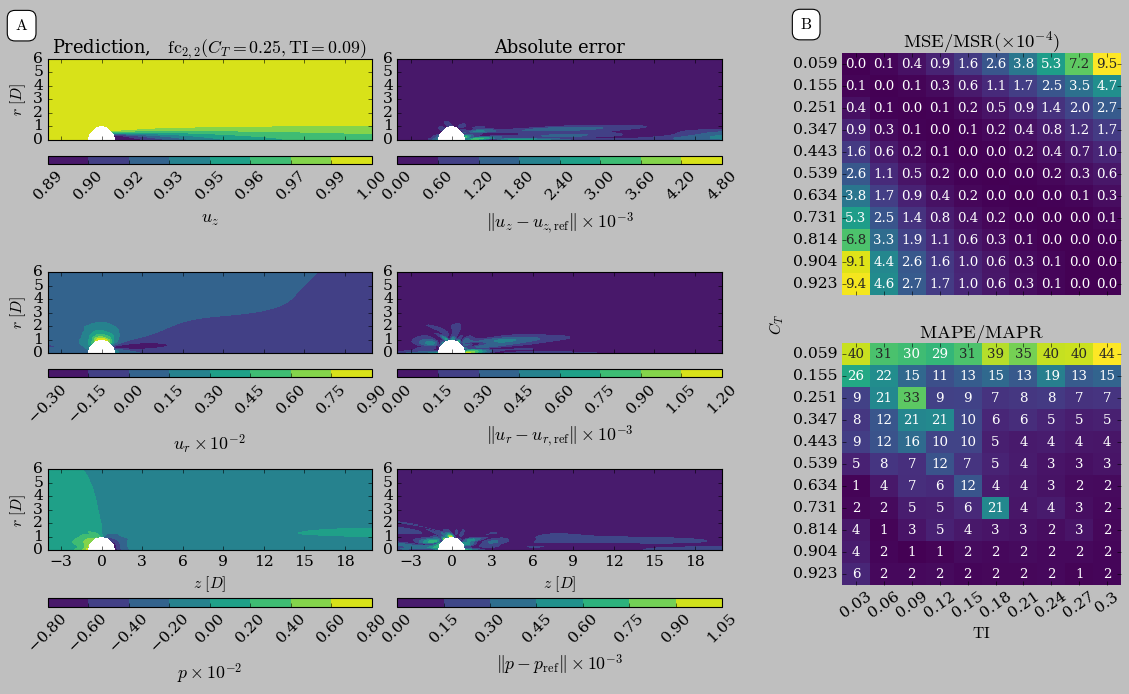

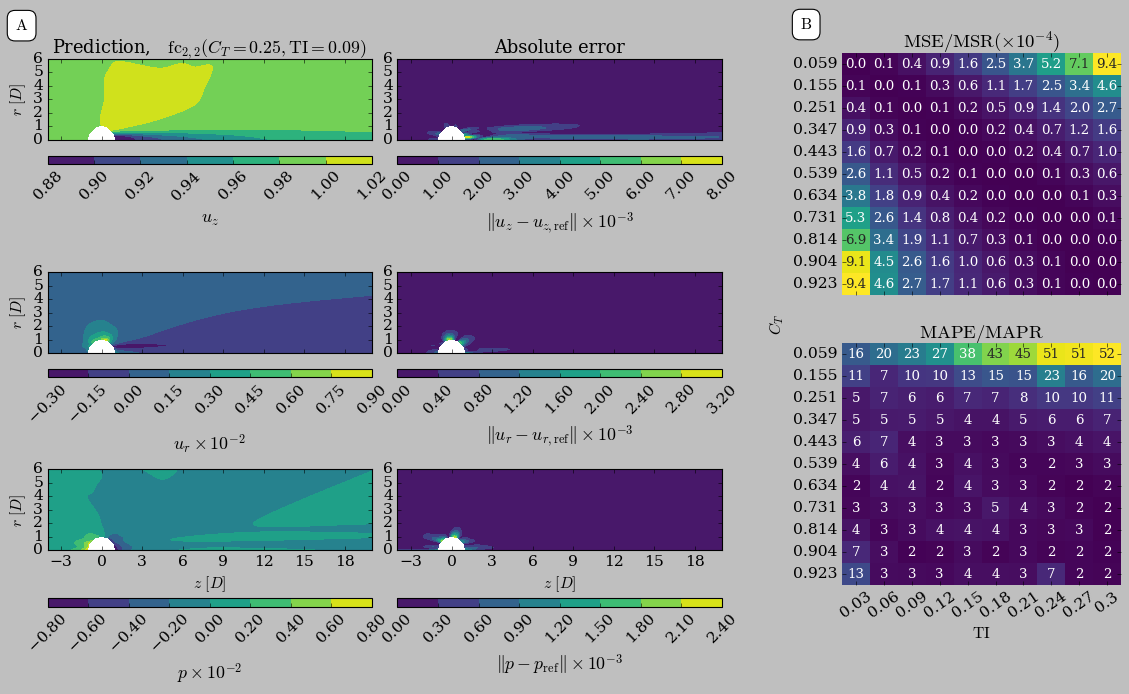

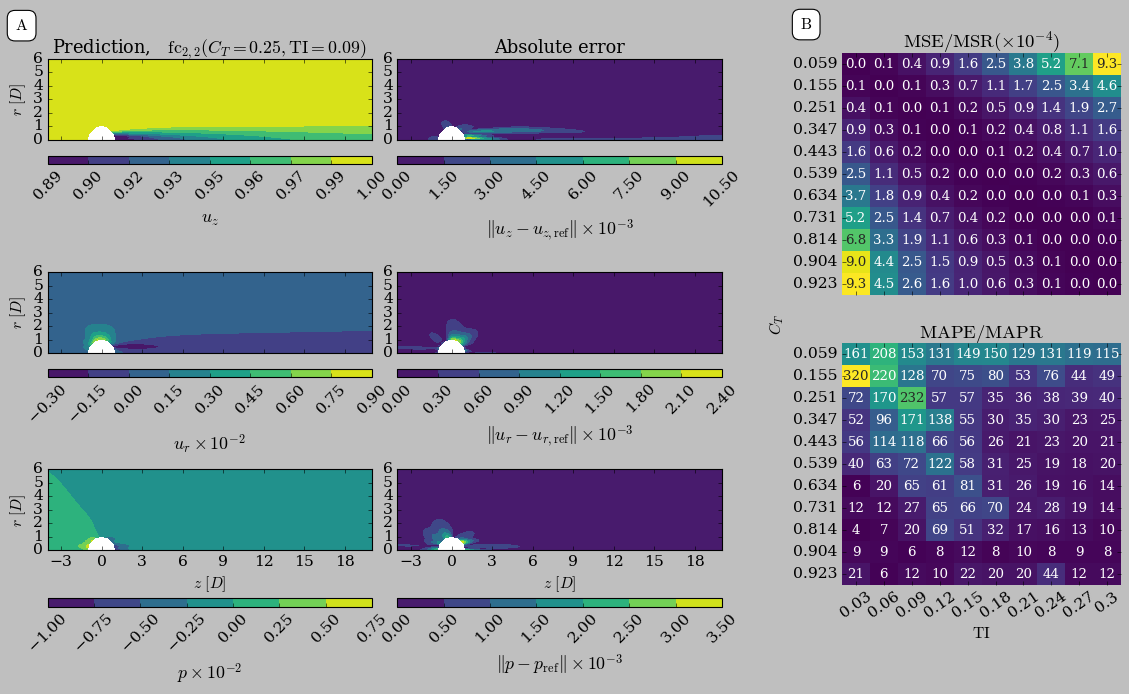

In [25]:
import numpy as np
import seaborn as sns

print("WARNING when plotting low CT plots having the horizontal cbar_orientation can make the colorbar accidentaly hide the +1 making the range look weird")
print("See below cell")


for model, plot_class, flowcase_metrics in zip(models, plot_classes, flowcase_metrics_list):

    fig = plt.figure(figsize=(14, 8), layout="constrained")
    subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2, 1.])
    axs0 = subfigs[0].subplots(3, 2, sharex=True)
    
    # FC 2,2
    flowcase = 2
    fc_label_prepend = r"$\mathrm{fc}_{2,2} (C_T=" 
    use_full_fc_set=False

    # # FC 0,9
    # flowcase = 9
    # fc_label_prepend = r"$\mathrm{fc}_{0,9} (C_T=" 
    # use_full_fc_set=True

    # # FC 10,0
    # flowcase = 90
    # fc_label_prepend = r"$\mathrm{fc}_{10,0} (C_T=" 
    # use_full_fc_set=True
    
    if use_full_fc_set:
        CT_fc = np.round(np.unique(plot_class.unscaled_df_all[flowcase]["CT"]).squeeze(),2)
        TI_fc = np.round(np.unique(plot_class.unscaled_df_all[flowcase]["TI_amb"]).squeeze(),2)
    else:
        CT_fc = np.round(DM.test_fc[0, flowcase],2)
        TI_fc = np.round(DM.test_fc[1, flowcase],2)
    print(f"Flowcase:\tCT={CT_fc}, TI={TI_fc}")

    # subfigs[0].suptitle(r"$\mathrm{fc}_{22} (C_T=" + f"{np.round(DM.test_fc[0, flowcase],2)}" + r",  \mathrm{TI}=" + f"{np.round(DM.test_fc[1, flowcase],2)}" + r")$", size=16)
    for i, var in enumerate(vars):
        ax_row = axs0[i, :]
        plot_class.plot_model_pred_contour(var, flowcase=flowcase, x_label=False, y_label=False, ax=ax_row[0], use_mask=True, cbar_orientation="horizontal", use_full_fc_set=use_full_fc_set)
        plot_class.plot_err_contour(var, flowcase=flowcase, x_label=False, y_label=False, ax=ax_row[1], use_mask=True, cbar_orientation="horizontal", use_full_fc_set=use_full_fc_set)
        if i == 0:
            ax_row[0].set_title("Prediction,   "+ fc_label_prepend + f"{np.round(CT_fc,2)}" + r",  \mathrm{TI}=" + f"{np.round(TI_fc, 2)}" + r")$", size=16)
            ax_row[1].set_title("Absolute error", size=16)
        for ax in ax_row:
            ax.set_aspect('equal')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

            ax.set_xlim([-4, 20])
            ax.set_ylim([0, 6 ])
        if i == 2:
            ax_row[0].set_xlabel(r'$z\ [D]$')
            ax_row[1].set_xlabel(r'$z\ [D]$')
        ax_row[0].set_ylabel(r'$r\ [D]$')

    metrics = ["MSE", "MAPE"]
    axs1 = subfigs[1].subplots(2, 1, sharex=True)
    options_dicts = [{"metric": "MSE", "title": "\n"+r"$\mathrm{MSE/MSR} (\times 10^{-4})$", "fmt": ".1f", "scale": 1e4}, 
                     {"metric": "MAPE", "title": "\n"+r"$\mathrm{MAPE/MAPR}$", "fmt": ".0f", "scale": 1}]

    subfigs[1].supylabel(r'$C_T$')
    for ax, options in zip(axs1, options_dicts):
        hm_df = flowcase_metrics[options["metric"]]*options["scale"]
        g = sns.heatmap(hm_df,
                        annot=True,
                        fmt=options["fmt"],
                        annot_kws={"size": 12},
                        cmap="viridis",
                        xticklabels=hm_df.columns.values.round(2),
                        yticklabels=hm_df.index.values.round(3),
                        cbar=False,
                        ax=ax,
                        )
        ax.set(xlabel=None)
        ax.set(ylabel=None)
        ax.set_title(options["title"])
        plt.sca(ax)
        plt.xticks(rotation=35)
        plt.yticks(rotation=0)
    axs1[1].set_xlabel(r'$\mathrm{TI}$')

    # insert figure a  and b text boxes
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText("A", prop=dict(size=20), frameon=True, loc='upper left', pad=0.1, borderpad=0.5)
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")


    plt.sca(axs0[0, 0])
    plt.text(-0.1, 1.5, r'$\mathrm{A}$', transform=plt.gca().transAxes, ha='left', va='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.sca(axs1[0])
    plt.text(-0.15, 1.15, r'$\mathrm{B}$', transform=plt.gca().transAxes, ha='left', va='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.savefig(f"../figures/flowcase_and_hms_{model}.pdf", bbox_inches='tight')